# Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold


# Reading data


In [2]:
data_raw = pd.read_csv('tested_molecules.csv')

# Calculating descriptors

In [3]:
def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles) #string to molecule object
    descriptors = {}
    for name, func in Descriptors.descList:
        descriptors[name] = func(mol)
    return descriptors


descriptor_data =data_raw['SMILES'].apply(calc_descriptors) 

# Adding data to a dataframe

In [4]:
df_molecules = pd.DataFrame(data_raw['SMILES']) #create a new dataframe for the smiles and descriptors

df_descriptors=pd.DataFrame(descriptor_data.tolist()) #making a dataframe for the descriptor data

df_molecules = pd.concat([df_molecules, df_descriptors], axis=1)
df_molecules['mol'] = df_molecules['SMILES'].apply(Chem.MolFromSmiles)
df_molecules['fp'] = df_molecules['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=64))
df_molecules['fp'] = df_molecules['fp'].apply(lambda x: x.ToBitString())

df_molecules['fp_numeric'] = df_molecules['fp'].apply(lambda x: int(x, 2))
df_molecules.drop(columns=['mol','fp'], inplace=True)

df_molecules


,SMILES,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,fp_numeric
0,C=C(C)c1nc(N)nc(N)n1,5.313889,5.313889,0.120833,0.120833,0.592228,9.545455,151.173,142.101,151.085795,...,0,0,0,0,0,0,0,0,0,90985811984611
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,11.238954,11.238954,0.225308,-0.366756,0.785414,10.470588,250.681,239.593,250.039672,...,0,0,0,0,0,0,0,0,0,4341146807336370466
2,C=CCNC(=O)CCCC(=O)NCC=C,11.090706,11.090706,0.049610,-0.049610,0.581062,9.066667,210.277,192.133,210.136828,...,0,0,0,0,0,0,0,0,0,9520752596039239428
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,11.892238,11.892238,0.076632,-0.457824,0.441090,10.411765,232.239,220.143,232.084792,...,0,0,0,0,0,0,0,0,0,9598797020023063460
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,11.693580,11.693580,0.012315,-0.498260,0.720343,9.933333,226.663,215.575,226.050905,...,0,0,0,0,0,0,0,0,0,1162164038796264096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,O=C1c2ccccc2[C@H](Nc2ccc3c(c2)OCCO3)N1Cc1ccco1,12.955843,12.955843,0.016627,-0.290408,0.764433,17.703704,362.385,344.241,362.126657,...,0,0,0,0,0,0,0,0,0,11111456593874736753
1112,O=S(=O)(Nc1cccc(-c2cn3ccsc3[nH+]2)c1)c1ccc(F)cc1,12.983770,12.983770,0.009487,-3.772852,0.594812,11.720000,374.442,361.338,374.042773,...,1,0,0,0,1,0,0,0,0,12303766233977819735
1113,Oc1c(C[NH+]2CCN(c3ccccn3)CC2)cc(Cl)c2cccnc12,10.579691,10.579691,0.249681,0.249681,0.753119,15.640000,355.849,335.689,355.132015,...,0,0,0,0,0,0,0,0,0,17775131185930519212
1114,c1ccc(-c2csc(N3CCN(c4ccccn4)CC3)n2)cc1,4.812249,4.812249,0.983396,0.983396,0.738254,14.956522,322.437,304.293,322.125218,...,0,0,0,0,1,0,0,0,0,15321645225114973219


# Splitting and scaling the descriptors

In [5]:
# For the filters to work it is better if all data is standardized so we will make a copy so we don't lose the actual values

df_molecules_copy = df_molecules.copy()
df_descriptors=df_molecules_copy.drop(columns=['SMILES'])
# We do not want to standardize binary columns, so we need to seperate these from the other columns
binary_columns = []#list of names of the binary columns
non_binary_columns=[]

for column in df_descriptors.columns:
    if df_molecules_copy[column].nunique() == 2 and df_descriptors[column].min() == 0 and df_descriptors[column].max() == 1:
        binary_columns.append(column)
    elif column not in binary_columns:
        non_binary_columns.append(column)

print(binary_columns)
print(non_binary_columns)


binary_descriptors=df_descriptors[binary_columns]
non_binary_descriptors=df_descriptors[non_binary_columns]

scaler = StandardScaler()
standardized_non_binary_cols=pd.DataFrame(scaler.fit_transform(non_binary_descriptors),
                                                   columns=non_binary_columns)

#put the binary columns together with the standardized non binary columns
df_standardized_descriptors = pd.concat([standardized_non_binary_cols, binary_descriptors], axis=1) 

['fr_Al_COO', 'fr_C_S', 'fr_Imine', 'fr_barbitur', 'fr_dihydropyridine', 'fr_guanido', 'fr_lactam', 'fr_lactone', 'fr_nitro', 'fr_nitro_arom', 'fr_oxazole', 'fr_priamide']
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_

# Applying filters

In [6]:
#Low variance filter:
var_filter = VarianceThreshold(threshold=0.001)
X_var_filtered = var_filter.fit_transform(df_standardized_descriptors)
df_filtered_once_descriptors = pd.DataFrame(X_var_filtered, columns=df_standardized_descriptors.columns[var_filter.get_support()])


# High-correlation filter
# Calculate the correlation matrix
corr_matrix = df_filtered_once_descriptors.corr().abs()
# Flatten the correlation matrix to get unique pairs of columns
corr_values = corr_matrix.unstack()


values = []
for row in corr_matrix.index:
    for col in corr_matrix.columns:
        if abs(corr_matrix.loc[row,col]) >= 0.9 and row != col: # it is unwanted to compare the same attributes ot each other 
            values.append(row)
            values.append(col)
values = list(set(values))
print(values)

#get df with filtered descriptors
df_filtered_twice_descriptors = df_filtered_once_descriptors.drop(columns = values)
df_filtered_twice_descriptors

['MaxPartialCharge', 'fr_ketone_Topliss', 'Kappa2', 'fr_nitrile', 'MinAbsPartialCharge', 'NumAromaticCarbocycles', 'Chi1n', 'MaxEStateIndex', 'FpDensityMorgan2', 'Chi3n', 'Chi2v', 'HeavyAtomCount', 'NHOHCount', 'fr_Al_OH', 'LabuteASA', 'Chi2n', 'fr_phenol_noOrthoHbond', 'Kappa1', 'NumHDonors', 'fr_COO', 'Chi4v', 'MolWt', 'MolMR', 'FpDensityMorgan1', 'fr_C_O', 'NumValenceElectrons', 'fr_COO2', 'ExactMolWt', 'Chi1v', 'Chi4n', 'Chi0', 'fr_Ar_NH', 'fr_phenol', 'FpDensityMorgan3', 'fr_ketone', 'SlogP_VSA6', 'Chi0n', 'fr_benzene', 'Chi1', 'Chi0v', 'Chi3v', 'MaxAbsPartialCharge', 'SMR_VSA7', 'fr_Al_OH_noTert', 'fr_C_O_noCOO', 'MinPartialCharge', 'HeavyAtomMolWt', 'MaxAbsEStateIndex', 'SMR_VSA2', 'fr_Nhpyrrole']


,MinAbsEStateIndex,MinEStateIndex,qed,SPS,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,...,fp_numeric,fr_Al_COO,fr_C_S,fr_Imine,fr_barbitur,fr_dihydropyridine,fr_guanido,fr_lactone,fr_oxazole,fr_priamide
0,-0.232493,0.763336,-0.622140,-1.013704,-0.932474,1.447500,-1.852097,1.753078,-1.975101,1.145141,...,-3.560565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.336260,0.445359,0.675637,-0.849048,0.733804,0.213314,-1.579349,1.147032,-0.496781,1.317520,...,-2.347052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.620226,0.652183,-0.697156,-1.098920,-0.849432,0.621825,-1.660946,1.426020,-3.066639,0.520635,...,-0.899127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.473124,0.385970,-1.637454,-0.859517,-0.807919,1.084269,-0.626353,0.729109,-1.967966,-0.039267,...,-0.877310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.823262,0.359600,0.238509,-0.944669,0.733803,2.477585,-1.338715,1.082697,-2.828947,0.095097,...,-3.235715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,-0.799789,0.495149,0.534697,0.438314,-0.815770,-0.034962,0.855834,-0.590931,0.984349,0.325995,...,-0.454456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1112,-0.838657,-1.775896,-0.604784,-0.626675,0.466791,0.288879,-0.669759,0.944268,-0.409738,0.901532,...,-0.121154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1113,0.468948,0.847363,0.458685,0.071012,0.733803,-0.059373,-0.173647,-1.062921,0.425767,-2.196445,...,1.408329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1114,4.463257,1.325849,0.358828,-0.050634,0.458623,0.447362,-0.380162,-1.236452,0.047075,-0.136179,...,0.722474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Getting filtered columns from original data

In [7]:
#Added smiles back to the df
df_filtered_twice_descriptors['SMILES'] = df_molecules['SMILES']
df_filtered_molecules = df_filtered_twice_descriptors
df_filtered_molecules

,MinAbsEStateIndex,MinEStateIndex,qed,SPS,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,...,fr_Al_COO,fr_C_S,fr_Imine,fr_barbitur,fr_dihydropyridine,fr_guanido,fr_lactone,fr_oxazole,fr_priamide,SMILES
0,-0.232493,0.763336,-0.622140,-1.013704,-0.932474,1.447500,-1.852097,1.753078,-1.975101,1.145141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C=C(C)c1nc(N)nc(N)n1
1,0.336260,0.445359,0.675637,-0.849048,0.733804,0.213314,-1.579349,1.147032,-0.496781,1.317520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1
2,-0.620226,0.652183,-0.697156,-1.098920,-0.849432,0.621825,-1.660946,1.426020,-3.066639,0.520635,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C=CCNC(=O)CCCC(=O)NCC=C
3,-0.473124,0.385970,-1.637454,-0.859517,-0.807919,1.084269,-0.626353,0.729109,-1.967966,-0.039267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21
4,-0.823262,0.359600,0.238509,-0.944669,0.733803,2.477585,-1.338715,1.082697,-2.828947,0.095097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,-0.799789,0.495149,0.534697,0.438314,-0.815770,-0.034962,0.855834,-0.590931,0.984349,0.325995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,O=C1c2ccccc2[C@H](Nc2ccc3c(c2)OCCO3)N1Cc1ccco1
1112,-0.838657,-1.775896,-0.604784,-0.626675,0.466791,0.288879,-0.669759,0.944268,-0.409738,0.901532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,O=S(=O)(Nc1cccc(-c2cn3ccsc3[nH+]2)c1)c1ccc(F)cc1
1113,0.468948,0.847363,0.458685,0.071012,0.733803,-0.059373,-0.173647,-1.062921,0.425767,-2.196445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Oc1c(C[NH+]2CCN(c3ccccn3)CC2)cc(Cl)c2cccnc12
1114,4.463257,1.325849,0.358828,-0.050634,0.458623,0.447362,-0.380162,-1.236452,0.047075,-0.136179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,c1ccc(-c2csc(N3CCN(c4ccccn4)CC3)n2)cc1


# Applying PCA

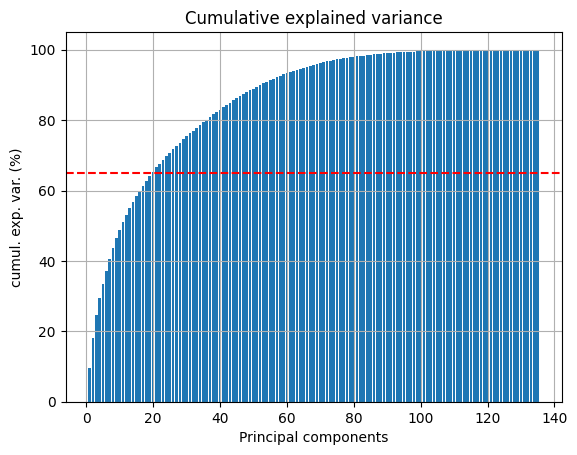

Number of principle components needed to cover 65% of the data: 20


In [8]:
X = df_filtered_molecules.drop(columns=['SMILES'])  # Looking at all the descriptors

# Standardizing the features
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)
variance = pca.explained_variance_ratio_

# Summing the variance and transforming to a percentage
cumulative_variance = np.cumsum(variance)*100

# Plotting the cumulative explained variance in a barplot
plt.bar(x=list(range(1,len(cumulative_variance)+1)), height=cumulative_variance)
plt.axhline(y=65, color='red', linestyle='--')

# Setting the title and labels
plt.title("Cumulative explained variance")
plt.xlabel("Principal components")
plt.ylabel("cumul. exp. var. (%)")
plt.grid(True)
plt.show()

# Deciding how many principle components are needed to cover 65% of the data 
n_principle_components = 0
variance = cumulative_variance[n_principle_components]
while variance <= 65: 
    n_principle_components += 1 
    variance = cumulative_variance[n_principle_components]
n_principle_components += 1  # Count 1 with the number of principle components, since the first index is 0 in stead of 1 
print('Number of principle components needed to cover 65% of the data:', n_principle_components)  


In [9]:
pca18 = PCA(n_components=n_principle_components, random_state=42)
pca18.fit(X)

# Maak een DataFrame van de loadings
loadings = pca18.components_
loading_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=X.columns)


PC_list = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18','PC19','PC20']
top_descriptors = {}
for PC in PC_list:
    sorted_PC = loading_df[PC].abs().sort_values(ascending=False)
    top_descriptors_PC = sorted_PC.index[:5]
    for descriptor in top_descriptors_PC:
        if descriptor in top_descriptors:
            top_descriptors[descriptor] += 1
        else:
            top_descriptors[descriptor] = 1
top_descriptors = dict(sorted(top_descriptors.items(), key=lambda item: item[1], reverse=True))
i=0
# Print the top descriptors for PC1-PC18
print('Top descriptors for PC1-PC20:')
print('Nr.    Count     Descriptor'	)
final_descriptor = []
for descriptor in top_descriptors:
    if top_descriptors[descriptor] > 2:
        i+=1
        print(i, "      ", top_descriptors[descriptor], '     ', descriptor)
        final_descriptor.append(descriptor)


print(final_descriptor)

Top descriptors for PC1-PC20:
Nr.    Count     Descriptor
1        3       fr_aniline
2        3       VSA_EState10
3        3       VSA_EState3
4        3       fr_imide
['fr_aniline', 'VSA_EState10', 'VSA_EState3', 'fr_imide']


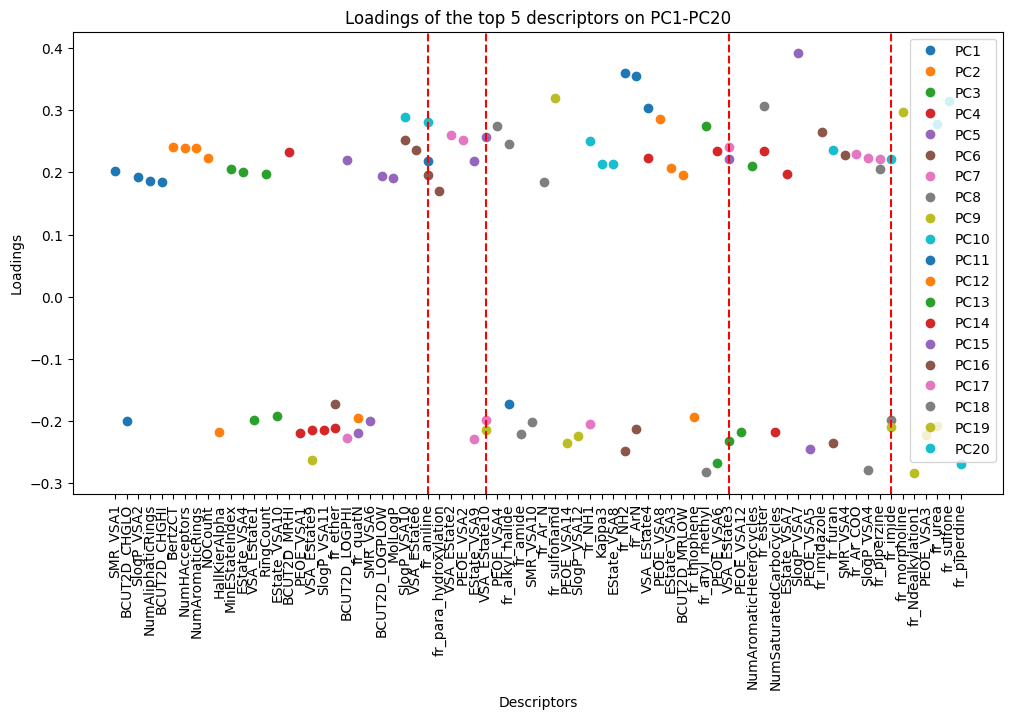

In [10]:
fig = plt.figure(figsize=(12, 6))
# Loop through the principle components
for i in range(n_principle_components):
    loadings_pc = pd.DataFrame(pca18.components_[i], columns=['loading'], index=X.columns)
    loadings_pc['absolute_loadings'] = loadings_pc['loading'].abs()

    # Sort loadings with descriptor with highest loading first 
    loadings_pc_sorted = loadings_pc.sort_values(by='absolute_loadings', ascending=False)
    top_5_descriptors = loadings_pc_sorted.head(5)

    # Plotting the loadings on PC1 and PC2 compared
    plt.plot(top_5_descriptors['loading'], label=f'PC{i+1}', marker="o", linestyle = "None")
  

# Plotting the loadings on PC1-PC18
for v_line in final_descriptor:
    plt.axvline(x=v_line, color='red', linestyle='--')
plt.title('Loadings of the top 5 descriptors on PC1-PC20')
plt.xlabel('Descriptors')
plt.ylabel('Loadings')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Create a csv file

In [11]:
df_descriptor_molecules = df_filtered_molecules[final_descriptor]
pd.DataFrame.to_csv(df_descriptor_molecules, 'descriptors.csv',index=False) 